In [1]:
from matplotlib.pyplot import *
import numpy as np
from matplotlib import *
import h5py
from matplotlib import cm
from tqdm import tqdm
import pandas as pd
import sklearn
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter

In [2]:
def read_data_map(file):
    hf = h5py.File(file, 'r')
    spectrums = np.array(hf.get('intensities'))
    positions = np.array(hf.get('position'))
    wavelengths = np.array(hf.get('wavelengths'))
    positions = np.delete(positions, 0, 0)
    spectrums = np.delete(spectrums, 0, 0)
    x = positions[:, 0]
    y = positions[:, 1]
    xy = np.lexsort((y, x))

    hf.close()
    return spectrums[xy], wavelengths, positions

In [3]:
find_index = lambda wavelenghts, w : np.argmin(np.abs(wavelenghts-w))

In [4]:
filename = ["340.h5", "355.h5", "370.h5"]

spectrums = []
for fname in filename:
    spectrum, wavelengths, positions = read_data_map(fname)
    spectrums.append(spectrum)

In [5]:
spectrums = np.array(spectrums)
spectrums = spectrums.reshape(spectrums.shape[0], 80, 80, -1)

In [6]:
pro_data_sum = np.array(spectrums)

for sp in range(pro_data_sum.shape[0]):
    spe = pro_data_sum[sp].reshape(pro_data_sum.shape[1]*pro_data_sum.shape[2], -1)
    norm = np.array([gaussian_filter(spe[i, :]/np.sum(spe[i, :]), sigma = 0) for i in range(0, spe.shape[0])]).reshape(pro_data_sum.shape[1], pro_data_sum.shape[2], -1)
    print(norm.shape)
    pro_data_sum[sp] = norm

(80, 80, 14336)
(80, 80, 14336)
(80, 80, 14336)


In [7]:
pro_data_sum.shape

(3, 80, 80, 14336)

In [8]:
scaled_pro = []

for i in range(0, pro_data_sum.shape[0]):
    # min_max_scaled = np.array([ (pro_data_sum[i, :, :, wv] - pro_data_sum[i].min())/(pro_data_sum[i].max() - pro_data_sum[i].min()) for wv in range(pro_data_sum.shape[-1])])
    min_max_scaled = np.array([ (gaussian_filter(pro_data_sum[i, :, :, wv], sigma = 0.7) - gaussian_filter(pro_data_sum[i, :, :, wv], sigma = 0.7).min())/
                                                (gaussian_filter(pro_data_sum[i, :, :, wv], sigma = 0.7).max() - gaussian_filter(pro_data_sum[i, :, :, wv], sigma = 0.7).min())
                               for wv in range(pro_data_sum.shape[-1])])
    scaled_pro.append(min_max_scaled)

scaled_pro = np.array(scaled_pro)

In [9]:
scaled_pro.shape

(3, 14336, 80, 80)

In [10]:
def gauss(x, sigma, val):
    return np.exp( - (x - val)**2 / (2 * sigma ** 2))

## Well-Exposedness

In [11]:
w_exposedness = gauss(scaled_pro, 0.2, 0.5)
weights_norm = w_exposedness.copy()
sum = np.sum(w_exposedness, axis = 0)
weights_norm = w_exposedness/sum
            
weights_norm = np.array(weights_norm)

In [12]:
from scipy.ndimage import convolve

kernel = (1.0/256)*np.array([[1, 4, 6, 4, 1],[4, 16, 24, 16, 4],[6, 24, 36, 24, 6], [4, 16, 24, 16, 4],[1, 4, 6, 4, 1]])

def add_padding(data, x_pad, y_pad):
    return np.pad(data, ((0, 0), (x_pad, x_pad), (y_pad, y_pad)), mode = 'mean')

def downscale(image):
    image_blur = convolve(image, kernel, mode = 'constant')
    return image_blur[::2, ::2]  

def upscale(image):
    image_up = np.zeros((2*image.shape[0], 2*image.shape[1]))
    image_up[::2, ::2] = image
    return convolve(image_up, 4*kernel, mode = 'constant')

def laplacian_pyramid(image, layers):
    laplace_pyra = []
    for energy in range(image.shape[0]):
        im1 = image[energy]
        lap_pyra = []
        for layer in range(layers):
            down = downscale(im1)
            up = upscale(down)
            lap_pyra.append(im1 - up)
            im1 = down
        lap_pyra.append(down)
        laplace_pyra.append(lap_pyra)
    return np.array(laplace_pyra, dtype = object)

def gaussian_pyramid(mask, layers):
    gaussian_pyra = []
    for energy in range(mask.shape[0]):
        im1 = mask[energy]
        gauss_pyra = [im1]
        for layer in range(0, layers):
            im1 = downscale(im1)
            gauss_pyra.append(im1)
        gaussian_pyra.append(gauss_pyra)
    return np.array(gaussian_pyra, dtype = object)

def final_pyramid(L, G):
    laplacian_final = []
    for i in range(L.shape[1]):
        laplacian_final.append((L[0, i]*G[0, i] + L[1, i]*G[1, i] + L[2, i]*G[2, i]))
    return np.array(laplacian_final, dtype = object)

def get_image(final_pyramid):
    rev_pyramid = final_pyramid[::-1]
    im = rev_pyramid[0]
    for i in range(1, len(rev_pyramid)):
        im = upscale(im) + rev_pyramid[i]
    return im

In [13]:
new_data1 = np.zeros(scaled_pro.shape[1:])
n_layers = 4

x_padding = 0
y_padding = 0

for j in tqdm(range(weights_norm.shape[1])):
    image_p = add_padding(scaled_pro[:, j], x_padding, y_padding)
    L = laplacian_pyramid(image_p, layers = n_layers)
    weights_p = add_padding(weights_norm[:, j], x_padding, y_padding)
    G = gaussian_pyramid(weights_p, layers = n_layers)
    final_pyra = final_pyramid(L, G)
    pyra_image = get_image(final_pyra)
    new_data1[j, :, :] = pyra_image[x_padding:pyra_image.shape[0]-x_padding, y_padding:pyra_image.shape[1]-y_padding]

100%|██████████| 14336/14336 [01:07<00:00, 211.57it/s]


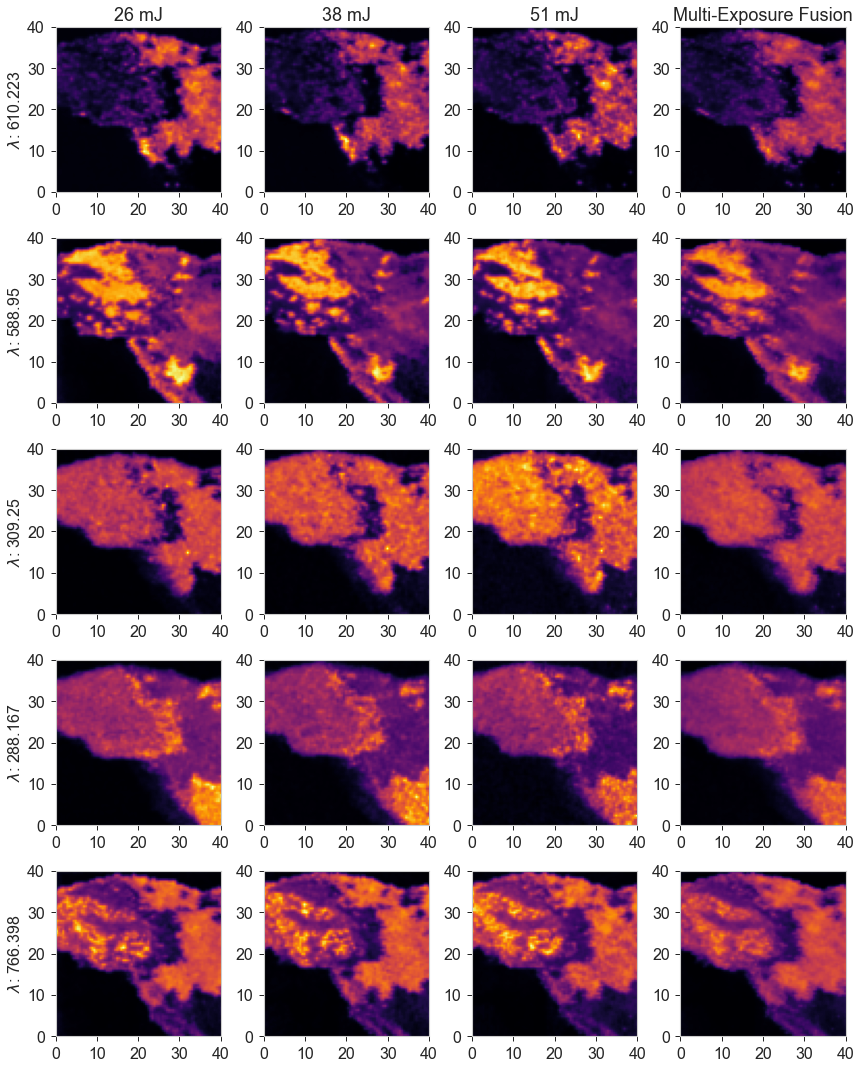

In [82]:
%matplotlib inline
fig, ax = subplots(5, 4, figsize = (12, 15))

wl = [610.223, 588.95, 309.25, 288.167, 766.398]


for w in range(len(wl)):
    axs = ax[w, 0]
    if w == 0:
        axs.set_title('26 mJ', fontsize = 18)
    axs.imshow(scaled_pro[0, find_index(wavelengths, wl[w])].T, extent = (0, 40, 0, 40), cmap = 'inferno', vmin = 0, vmax = 1)
    axs.set_ylabel(r'$\lambda$: ' + f'{wl[w]}', fontsize = 16)
    axs.set_xticks([0, 10, 20, 30, 40])
    axs.set_yticks([0, 10, 20, 30, 40])
    axs.set_xticklabels([0, 10, 20, 30, 40], fontsize = 16)
    axs.set_yticklabels([0, 10, 20, 30, 40], fontsize = 16)
    axs.tick_params(
                bottom=True, top=False,
                left=True, right=False, length = 5, width = 1)
    axs.grid(False)

    axs = ax[w, 1]
    if w == 0:
        axs.set_title('38 mJ', fontsize = 18)
    axs.imshow(scaled_pro[1, find_index(wavelengths, wl[w])].T, extent = (0, 40, 0, 40), cmap = 'inferno', vmin = 0, vmax = 1)
    axs.set_xticks([0, 10, 20, 30, 40])
    axs.set_yticks([0, 10, 20, 30, 40])
    axs.set_xticklabels([0, 10, 20, 30, 40], fontsize = 16)
    axs.set_yticklabels([0, 10, 20, 30, 40], fontsize = 16)
    axs.tick_params(
                bottom=True, top=False,
                left=True, right=False, length = 5, width = 1)
    axs.grid(False)

    axs = ax[w, 2]
    if w == 0:
        axs.set_title('51 mJ', fontsize = 18)
    axs.imshow(scaled_pro[2, find_index(wavelengths, wl[w])].T, extent = (0, 40, 0, 40), cmap = 'inferno', vmin = 0, vmax = 1)
    axs.set_xticks([0, 10, 20, 30, 40])
    axs.set_yticks([0, 10, 20, 30, 40])
    axs.set_xticklabels([0, 10, 20, 30, 40], fontsize = 16)
    axs.set_yticklabels([0, 10, 20, 30, 40], fontsize = 16)
    axs.tick_params(
                bottom=True, top=False,
                left=True, right=False, length = 5, width = 1)
    axs.grid(False)

    axs = ax[w, 3]
    if w == 0:
        axs.set_title('Multi-Exposure Fusion', fontsize = 18)
    axs.imshow(new_data1[find_index(wavelengths, wl[w])].T, extent = (0, 40, 0, 40), cmap = 'inferno', vmin = 0, vmax = 1)
    axs.set_xticks([0, 10, 20, 30, 40])
    axs.set_yticks([0, 10, 20, 30, 40])
    axs.set_xticklabels([0, 10, 20, 30, 40], fontsize = 16)
    axs.set_yticklabels([0, 10, 20, 30, 40], fontsize = 16)
    axs.tick_params(
                bottom=True, top=False,
                left=True, right=False, length = 5, width = 1)
    axs.grid(False)

fig.tight_layout()
# fig.savefig('libs_energies.jpg', dpi = 300)

Text(0.5, 1.0, 'Reference')

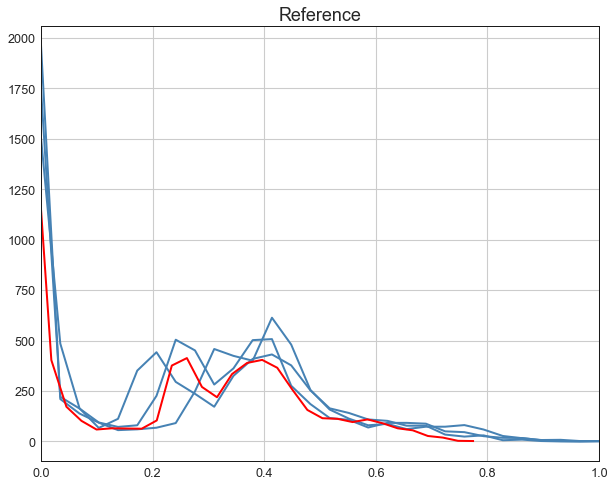

In [69]:
fig, ax = subplots(1, 1, figsize = (10, 8))

wl = [610.223, 588.95, 309.25, 288.167, 766.398]
wl_used = wl[3]
n_bins = 30


axs = ax
hist_base1, _ = np.histogram(scaled_pro[0, find_index(wavelengths, wl_used)].reshape(6400), bins = n_bins)
hist_base2, _ = np.histogram(scaled_pro[1, find_index(wavelengths, wl_used)].reshape(6400), bins = n_bins)
hist_base3, _ = np.histogram(scaled_pro[2, find_index(wavelengths, wl_used)].reshape(6400), bins = n_bins)
x_bins = np.linspace(scaled_pro[0, find_index(wavelengths, wl_used)].min(), scaled_pro[0, find_index(wavelengths, wl_used)].max(), n_bins)
axs.plot(x_bins, hist_base1, color = 'steelblue', lw = 2)
axs.plot(x_bins, hist_base2, color = 'steelblue', lw = 2)
axs.plot(x_bins, hist_base3, color = 'steelblue', lw = 2)
hist_pyra, _ = np.histogram(new_data1[find_index(wavelengths, wl_used)].reshape(6400), bins = n_bins)
x_bins = np.linspace(new_data1[find_index(wavelengths, wl_used)].min(), new_data1[find_index(wavelengths, wl_used)].max(), n_bins)
axs.plot(x_bins, hist_pyra, color = 'red', lw = 2)
axs.set_xlim(0, 1)
axs.set_title('Reference', fontsize = 18)

In [65]:
new_data1.max()

0.9735608024676581

In [66]:
scaled_pro.max()

1.0

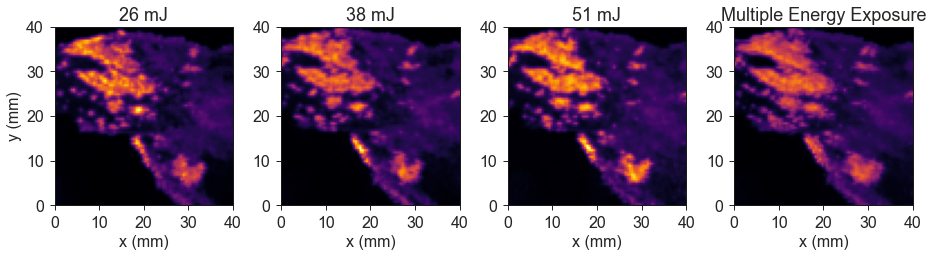

In [15]:
%matplotlib inline

matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['axes.edgecolor'] = '0.1'

fig, ax = subplots(1, 4, figsize = (13, 5))

elements = ['Li', 'Si', 'K', 'Na', 'Al']
w = find_index(wavelengths, 588.99)

maps = scaled_pro[:, w]

axs = ax[0]
axs.set_title(r'26 mJ', fontsize = 18)
axs.imshow(maps[0].T, extent = (0, 40, 0, 40), cmap = 'inferno', vmin = 0, vmax = 1)
axs.set_xticks([0, 10, 20, 30, 40])
axs.set_yticks([0, 10, 20, 30, 40])
axs.set_xticklabels([0, 10, 20, 30, 40], fontsize = 16)
axs.set_yticklabels([0, 10, 20, 30, 40], fontsize = 16)
axs.set_ylabel(f'y (mm)', fontsize = 16)
axs.set_xlabel(f'x (mm)', fontsize = 16)
axs.tick_params(
            bottom=True, top=False,
            left=True, right=False, length = 5, width = 1)
axs.grid(False)

axs = ax[1]
axs.set_title(r'38 mJ', fontsize = 18)
axs.imshow(maps[1].T, extent = (0, 40, 0, 40), cmap = 'inferno', vmin = 0, vmax = 1)
axs.set_xticks([0, 10, 20, 30, 40])
axs.set_yticks([0, 10, 20, 30, 40])
axs.set_xticklabels([0, 10, 20, 30, 40], fontsize = 16)
axs.set_yticklabels([0, 10, 20, 30, 40], fontsize = 16)
axs.set_xlabel(f'x (mm)', fontsize = 16)
axs.tick_params(
            bottom=True, top=False,
            left=True, right=False, length = 5, width = 1)
axs.grid(False)

axs = ax[2]
axs.set_title(r'51 mJ', fontsize = 18)
axs.imshow(maps[2].T, extent = (0, 40, 0, 40), cmap = 'inferno', vmin = 0, vmax = 1)
axs.set_xticks([0, 10, 20, 30, 40])
axs.set_yticks([0, 10, 20, 30, 40])
axs.set_xticklabels([0, 10, 20, 30, 40], fontsize = 16)
axs.set_yticklabels([0, 10, 20, 30, 40], fontsize = 16)
axs.set_xlabel(f'x (mm)', fontsize = 16)
axs.tick_params(
            bottom=True, top=False,
            left=True, right=False, length = 5, width = 1)
axs.grid(False)

axs = ax[3]
axs.set_title('Multiple Energy Exposure', fontsize = 18)
axs.imshow(new_data1[w].T, extent = (0, 40, 0, 40), cmap = 'inferno', vmin = 0, vmax = 1)
axs.set_xticks([0, 10, 20, 30, 40])
axs.set_yticks([0, 10, 20, 30, 40])
axs.set_xticklabels([0, 10, 20, 30, 40], fontsize = 16)
axs.set_yticklabels([0, 10, 20, 30, 40], fontsize = 16)
axs.set_xlabel(f'x (mm)', fontsize = 16)
axs.tick_params(
            bottom=True, top=False,
            left=True, right=False, length = 5, width = 1)
axs.grid(False)

fig.tight_layout()
# fig.savefig('multiple_energy_libs_na.jpg', dpi = 300, bbox_inches = 'tight')

In [14]:
wl = [610.22, 288.16, 766.5, 588.99, 309.27]
data1 = np.array([new_data1[find_index(wavelengths, wl[w])] for w in range(len(wl))])

init = np.array([[1, 1, 1, 0, 1],
                 [0, 1, 0, 1, 1],
                 [0, 1, 0, 0, 0],
                 [0, 1, 1, 0, 1],
                 [0, 0, 0, 0, 0]])

model1 = KMeans(n_clusters = 5, init = init*0.5)

data = data1.reshape(data1.shape[0], -1).T
labels = model1.fit_predict(data)

c:\Users\tomas\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


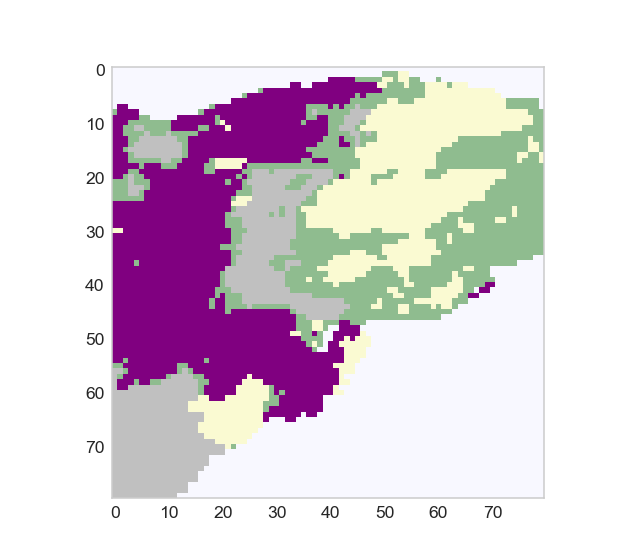

In [15]:
subplots()

nx, ny = 80, 80
colors = ['Purple', 'lightgoldenrodyellow', 'silver','darkseagreen', 'ghostwhite']
cmp_libs = ListedColormap(colors)

imshow(labels.reshape(nx, ny).T[::, ::-1], cmap = cmp_libs, interpolation = 'nearest')
grid()

# Between Element Lines

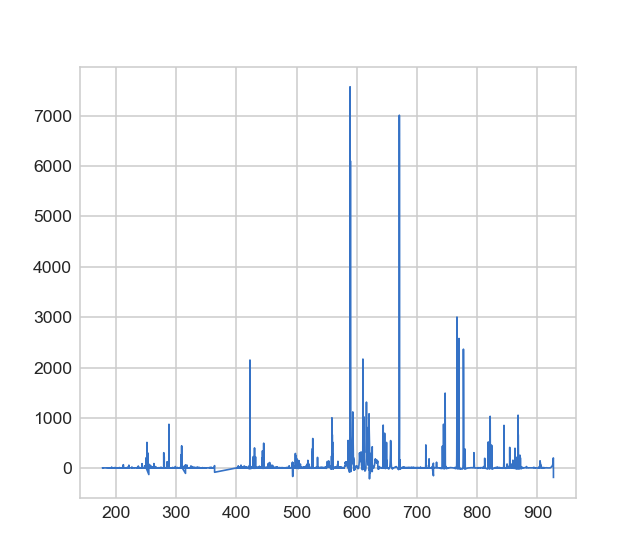

In [20]:
subplots()
plot(wavelengths, np.mean(spectrums[0], axis = (0, 1)))

In [36]:
Li = [610.223, 460.236, 812.562]
Si = [288.167, 251.590, 252.817]
K = [769.811, 766.398, 693.80]
Na = [568.766, 588.95, 819.40]
Al = [309.25, 308.169, 257.481]

from scipy.ndimage import gaussian_filter

energy = 0
sig = 0.7

Li_lines = np.array([gaussian_filter(pro_data_sum[energy, :, :, find_index(wavelengths, Li[i])], sigma = sig) for i in range(len(Li))])
Si_lines = np.array([gaussian_filter(pro_data_sum[energy, :, :, find_index(wavelengths, Si[i])], sigma = sig) for i in range(len(Si))])
K_lines  = np.array([gaussian_filter(pro_data_sum[energy, :, :, find_index(wavelengths,  K[i])], sigma = sig) for i in range(len(K ))])
Na_lines = np.array([gaussian_filter(pro_data_sum[energy, :, :, find_index(wavelengths, Na[i])], sigma = sig) for i in range(len(Na))])
Al_lines = np.array([gaussian_filter(pro_data_sum[energy, :, :, find_index(wavelengths, Al[i])], sigma = sig) for i in range(len(Al))])

lines = np.stack([Li_lines, Si_lines, K_lines, Na_lines, Al_lines], axis = 3)

In [37]:
scaled_pro = []
for i in range(0, pro_data_sum.shape[0]):
    # min_max_scaled = np.array([ (pro_data_sum[i, :, :, wv] - pro_data_sum[i].min())/(pro_data_sum[i].max() - pro_data_sum[i].min()) for wv in range(pro_data_sum.shape[-1])])
    min_max_scaled = np.array([ (lines[i, :, :, wv] - lines[i, :, :, wv].min())/(lines[i, :, :, wv].max() - lines[i, :, :, wv].min()) 
                               for wv in range(lines.shape[-1])])
    scaled_pro.append(min_max_scaled)

scaled_pro = np.array(scaled_pro)

In [38]:
w_exposedness = gauss(scaled_pro, 0.2, 0.5)
weights_norm = w_exposedness.copy()
sum = np.sum(w_exposedness, axis = 0)
weights_norm = w_exposedness/sum
            
weights_norm = np.array(weights_norm)

In [39]:
new_data1 = np.zeros(scaled_pro.shape[1:])
n_layers = 4

x_padding = 0
y_padding = 0

for j in tqdm(range(weights_norm.shape[1])):
    image_p = add_padding(scaled_pro[:, j], x_padding, y_padding)
    L = laplacian_pyramid(image_p, layers = n_layers)
    weights_p = add_padding(weights_norm[:, j], x_padding, y_padding)
    G = gaussian_pyramid(weights_p, layers = n_layers)
    final_pyra = final_pyramid(L, G)
    pyra_image = get_image(final_pyra)
    new_data1[j, :, :] = pyra_image[x_padding:pyra_image.shape[0]-x_padding, y_padding:pyra_image.shape[1]-y_padding]

100%|██████████| 5/5 [00:00<00:00, 181.71it/s]


In [42]:
scaled_pro.shape

(3, 5, 80, 80)

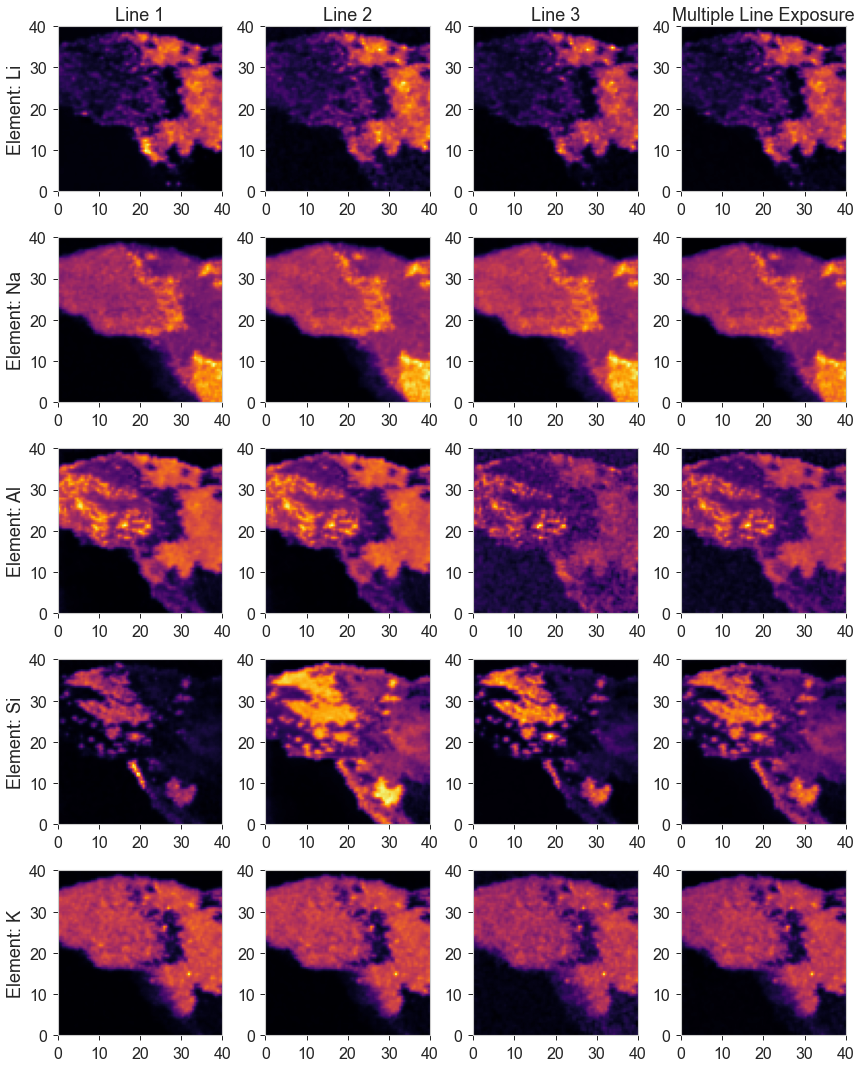

In [47]:
%matplotlib inline
fig, ax = subplots(5, 4, figsize = (12, 15))

wl = [610.22, 588.99, 309.27, 288.16, 766.5]
elements = ['Li', 'Na', 'Al', 'Si', 'K']

for w in range(len(wl)):
    axs = ax[w, 0]
    if w == 0:
        axs.set_title('Line 1', fontsize = 18)
    axs.imshow(scaled_pro[0, w].T, extent = (0, 40, 0, 40), cmap = 'inferno', vmin = 0, vmax = 1)
    axs.set_ylabel(f'Element: {elements[w]}', fontsize = 18)
    axs.set_xticks([0, 10, 20, 30, 40])
    axs.set_yticks([0, 10, 20, 30, 40])
    axs.set_xticklabels([0, 10, 20, 30, 40], fontsize = 16)
    axs.set_yticklabels([0, 10, 20, 30, 40], fontsize = 16)
    axs.tick_params(
                bottom=True, top=False,
                left=True, right=False, length = 5, width = 1)
    axs.grid(False)

    axs = ax[w, 1]
    if w == 0:
        axs.set_title('Line 2', fontsize = 18)
    axs.imshow(scaled_pro[1, w].T, extent = (0, 40, 0, 40), cmap = 'inferno', vmin = 0, vmax = 1)
    axs.set_xticks([0, 10, 20, 30, 40])
    axs.set_yticks([0, 10, 20, 30, 40])
    axs.set_xticklabels([0, 10, 20, 30, 40], fontsize = 16)
    axs.set_yticklabels([0, 10, 20, 30, 40], fontsize = 16)
    axs.tick_params(
                bottom=True, top=False,
                left=True, right=False, length = 5, width = 1)
    axs.grid(False)

    axs = ax[w, 2]
    if w == 0:
        axs.set_title('Line 3', fontsize = 18)
    axs.imshow(scaled_pro[2, w].T, extent = (0, 40, 0, 40), cmap = 'inferno', vmin = 0, vmax = 1)
    axs.set_xticks([0, 10, 20, 30, 40])
    axs.set_yticks([0, 10, 20, 30, 40])
    axs.set_xticklabels([0, 10, 20, 30, 40], fontsize = 16)
    axs.set_yticklabels([0, 10, 20, 30, 40], fontsize = 16)
    axs.tick_params(
                bottom=True, top=False,
                left=True, right=False, length = 5, width = 1)
    axs.grid(False)

    axs = ax[w, 3]
    if w == 0:
        axs.set_title('Multiple Line Exposure', fontsize = 18)
    axs.imshow(new_data1[w].T, extent = (0, 40, 0, 40), cmap = 'inferno', vmin = 0, vmax = 1)
    axs.set_xticks([0, 10, 20, 30, 40])
    axs.set_yticks([0, 10, 20, 30, 40])
    axs.set_xticklabels([0, 10, 20, 30, 40], fontsize = 16)
    axs.set_yticklabels([0, 10, 20, 30, 40], fontsize = 16)
    axs.tick_params(
                bottom=True, top=False,
                left=True, right=False, length = 5, width = 1)
    axs.grid(False)

fig.tight_layout()
# fig.savefig('libs_lines.jpg', dpi = 300)

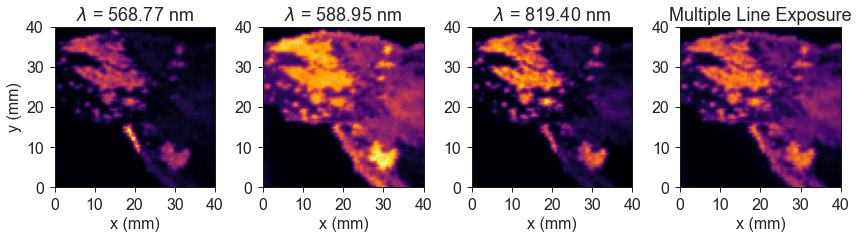

In [22]:
%matplotlib inline

matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['axes.edgecolor'] = '0.1'

fig, ax = subplots(1, 4, figsize = (12, 5))

elements = ['Li', 'Si', 'K', 'Na', 'Al']

maps = scaled_pro[:, 3]

axs = ax[0]
axs.set_title(r'$\lambda$ = 568.77 nm', fontsize = 18)
axs.imshow(maps[0].T, extent = (0, 40, 0, 40), cmap = 'inferno', vmin = 0, vmax = 1)
axs.set_xticks([0, 10, 20, 30, 40])
axs.set_yticks([0, 10, 20, 30, 40])
axs.set_xticklabels([0, 10, 20, 30, 40], fontsize = 16)
axs.set_yticklabels([0, 10, 20, 30, 40], fontsize = 16)
axs.set_ylabel(f'y (mm)', fontsize = 16)
axs.set_xlabel(f'x (mm)', fontsize = 16)
axs.tick_params(
            bottom=True, top=False,
            left=True, right=False, length = 5, width = 1)
axs.grid(False)

axs = ax[1]
axs.set_title(r'$\lambda$ = 588.95 nm', fontsize = 18)
axs.imshow(maps[1].T, extent = (0, 40, 0, 40), cmap = 'inferno', vmin = 0, vmax = 1)
axs.set_xticks([0, 10, 20, 30, 40])
axs.set_yticks([0, 10, 20, 30, 40])
axs.set_xticklabels([0, 10, 20, 30, 40], fontsize = 16)
axs.set_yticklabels([0, 10, 20, 30, 40], fontsize = 16)
axs.set_xlabel(f'x (mm)', fontsize = 16)
axs.tick_params(
            bottom=True, top=False,
            left=True, right=False, length = 5, width = 1)
axs.grid(False)

axs = ax[2]
axs.set_title(r'$\lambda$ = 819.40 nm', fontsize = 18)
axs.imshow(maps[2].T, extent = (0, 40, 0, 40), cmap = 'inferno', vmin = 0, vmax = 1)
axs.set_xticks([0, 10, 20, 30, 40])
axs.set_yticks([0, 10, 20, 30, 40])
axs.set_xticklabels([0, 10, 20, 30, 40], fontsize = 16)
axs.set_yticklabels([0, 10, 20, 30, 40], fontsize = 16)
axs.set_xlabel(f'x (mm)', fontsize = 16)
axs.tick_params(
            bottom=True, top=False,
            left=True, right=False, length = 5, width = 1)
axs.grid(False)

axs = ax[3]
axs.set_title('Multiple Line Exposure', fontsize = 18)
axs.imshow(new_data1[3].T, extent = (0, 40, 0, 40), cmap = 'inferno', vmin = 0, vmax = 1)
axs.set_xticks([0, 10, 20, 30, 40])
axs.set_yticks([0, 10, 20, 30, 40])
axs.set_xticklabels([0, 10, 20, 30, 40], fontsize = 16)
axs.set_yticklabels([0, 10, 20, 30, 40], fontsize = 16)
axs.set_xlabel(f'x (mm)', fontsize = 16)
axs.tick_params(
            bottom=True, top=False,
            left=True, right=False, length = 5, width = 1)
axs.grid(False)

fig.tight_layout()
fig.savefig('multiple_lines_libs_plasma.jpg', dpi = 300, bbox_inches = 'tight')

In [26]:
from sklearn.cluster import KMeans

init = np.array([[1, 1, 0, 0, 1],
                 [0, 1, 0, 1, 1],
                 [0, 1, 0, 0, 0],
                 [0, 1, 1, 0, 1],
                 [0, 0, 0, 0, 0]])

model = KMeans(n_clusters = 5, init = init*0.5)
data = new_data1.reshape(new_data1.shape[0], -1).T
labels = model.fit_predict(data)

c:\Users\tomas\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


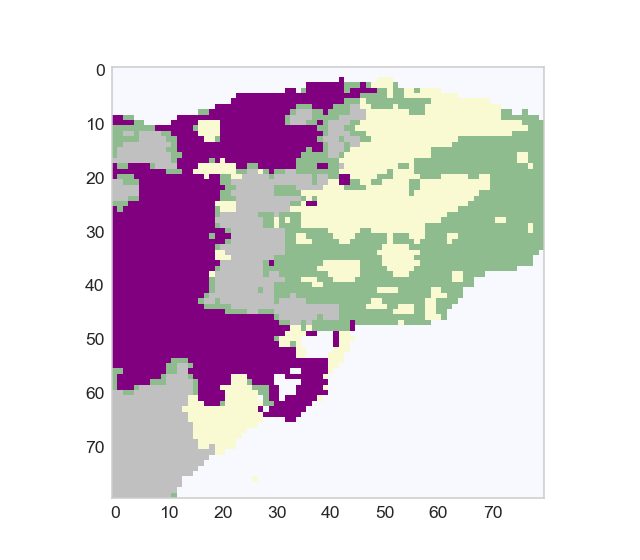

In [27]:
subplots()

nx, ny = 80, 80
colors = ['Purple', 'lightgoldenrodyellow', 'silver','darkseagreen', 'ghostwhite']
cmp_libs = ListedColormap(colors[:5])

imshow(labels.reshape(nx, ny).T[::, ::-1], interpolation = 'nearest', cmap = cmp_libs)
grid()

In [47]:
scaled_pro.shape

(3, 5, 80, 80)

In [53]:
lines_t = np.transpose(scaled_pro, axes = (2, 3, 1, 0))
lines_t = lines_t.reshape(lines_t.shape[0]*lines_t.shape[1], -1)

In [54]:
from sklearn.cluster import KMeans

init = np.array([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

model = KMeans(n_clusters = 5, init = init)
labels = model.fit_predict(lines_t)

c:\Users\tomas\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


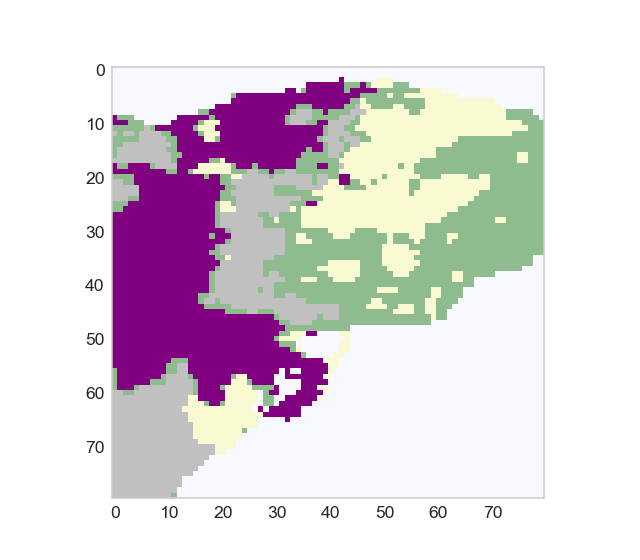

In [55]:
subplots()
imshow(labels.reshape(80, 80).T[::, ::-1], cmap = cmp_libs, interpolation = 'nearest')
grid()